# Lesson 0044 - MNIST Variational Autoencoder
In this lesson, we pick up the autoencoder from [lesson 0041](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0041_mnist_autoencoder.ipynb).<br>
However, we extend the approach from [lesson 0041](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0041_mnist_autoencoder.ipynb) by adding some randomness. The idea in [lesson 0041](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0041_mnist_autoencoder.ipynb) was to reduce an image to only a few data points in the encoder, and then to reconstruct the original image from these condensed data using the decoder. The problem with this approach is, that there is no guarantee, that if the encoder maps images to similar vectors, then the reconstruction from these two vectors is not necessariliy similar. Therefore, in the Variational Autoencoder, the encoder maps the input data to a vector which is then infused with random noise. The idea is here, that one inputimage can be mapped to very many of these randomized vectors, however, the decoder must reproduce one single image from these random vectors. Thereby, the Variational Autoencoder guarantees, that similar images are mapped to similar results.<br>
We start with stealing code from [lesson 0041](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0041_mnist_autoencoder.ipynb).

In [1]:
import tensorflow as tf

tf.set_random_seed( 1234567890 )

print( tf.__version__ )

1.13.1


In [2]:
( train_x, train_y ),( test_x, test_y ) = tf.keras.datasets.mnist.load_data()

In [3]:
import numpy as np

np.random.seed( 1234567890 )

print( np.__version__ )

1.16.2


In [4]:
import matplotlib
import matplotlib.pyplot as plt

print( matplotlib.__version__ )

3.0.3


In [5]:
mu = np.mean( train_x )

sigma = np.std( train_x )



train_x = ( train_x - mu ) / sigma

test_x = ( test_x - mu ) / sigma




train_x = np.reshape( train_x, [ 60000, 28, 28, 1 ] )

test_x = np.reshape( test_x, [ 10000, 28, 28, 1 ] )

In [6]:
import keras
from keras import models
from keras import layers
from keras import backend as K

print( keras.__version__ )

2.2.4


Using TensorFlow backend.


Now, we buold the __encoder__. 

In [7]:
input_encoder = keras.engine.input_layer.Input( shape = ( 28, 28, 1, ) )

encoder_layer1 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ) )( input_encoder )

encoder_layer2 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ) )( encoder_layer1 )

encoder_layer3 = layers.MaxPooling2D()( encoder_layer2 )

encoder_layer4 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ) )( encoder_layer3 )

encoder_layer5 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ) )( encoder_layer4 )

encoder_layer6 = layers.Flatten()( encoder_layer5 )

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\rhopi\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Up until now, we have the __encoder__ from [lesson 0041](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0041_mnist_autoencoder.ipynb). Next, we introduce the variables __mu__ and __log_var__ which we need for the random sampling. Then, we define a function that facilitates the sampling.

In [8]:
mu = layers.Dense( 2 )( encoder_layer6 )

log_var = layers.Dense( 2 )( encoder_layer6 )

In [9]:
def sampling( args ):
    
    m, var = args
    
    epsilon = K.random_normal( shape = K.shape( var, ), mean = 0, stddev = 1.0 )
    
    return m + K.exp( var / 2 ) * epsilon

Now, we use the [lambda-layer](https://keras.io/layers/core/) in Keras to create our random sampler.

In [10]:
encoder_output = layers.Lambda( sampling, output_shape = ( 2, ) )( [ mu, log_var ] )

encoder = keras.Model( input_encoder, encoder_output )

encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 24, 64)   1664        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 20, 20, 64)   102464      conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 10, 10, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

We steal the __decoder__ from [lesson 0041](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0041_mnist_autoencoder.ipynb).

In [11]:
input_decoder = keras.engine.input_layer.Input( shape = ( 2, ) )

decoder_layer1 = layers.Dense( 28 * 28, activation = layers.LeakyReLU( alpha = 0.3 ) )( input_decoder )

decoder_layer2 = layers.Reshape( ( 28, 28, 1, ) )( decoder_layer1 )

decoder_layer3 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "SAME" )( decoder_layer2 )

decoder_layer4 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "SAME" )( decoder_layer3 )

decoder_layer5 = layers.Conv2D( 1, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "SAME" )( decoder_layer4 )

decoder = keras.Model( input_decoder, decoder_layer5 )

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               2352      
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 1)         1601      
Total params: 108,081
Trainable params: 108,081
Non-trainable params: 0
_________________________________________________________________


In [12]:
variational_autoencoder = keras.Model( input_encoder, decoder( encoder( input_encoder ) ) )

variational_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_1 (Model)              (None, 2)                 310084    
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         108081    
Total params: 418,165
Trainable params: 418,165
Non-trainable params: 0
_________________________________________________________________


Now, we need to define our custom loss. On the one hand, we want to minimize the difference between the input and the output, which is why __mse__ is a good loss.<br>
However, we also want the normal distribution defined by __mu__ and __log_var__ to be similar to the Gaussian Normal distribution. This forces the model to map images that are similar in the input space to similar vectors in the latent space and from there to similar vectors in the output space.<br>
In our special case, the loss for the similarity with the Gaussian can be defined as $-0.5 * \sum \left( 1 + \text{ log_var } - \text{ mu }^{ 2 } - exp\left( \text{ log_var }\right)\right)$.<br>
In the definition of the loss, we weigh the __mse__ $1000$ times more heavy than the similarity with the Gaussian. This way, we force the variational autoencoder to put more emphasis on a correct reconstruction of the input image than on the similarity with the Gaussian.

In [13]:
def my_loss( x, y ):
    
    loss1 = K.mean( K.square( x - y ) )
    
    loss2 = - 0.5 * K.sum( 1.0 + log_var - K.square( mu ) - K.exp( log_var ) )
    
    return 1000 * loss1 + loss2

In [14]:
variational_autoencoder.compile( optimizer = keras.optimizers.SGD( lr = 0.000005, momentum = 0.9, decay = 0,
                                                                  nesterov = False ), loss = my_loss, 
                                                                    metrics = None )

variational_autoencoder.fit( train_x, train_x, validation_data = ( test_x, test_x ), batch_size = 25, epochs = 200 )

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 26s 434us/step - loss: 701.2888 - val_loss: 640.7879
Epoch 2/200
60000/60000 [==============================] - 23s 382us/step - loss: 636.9372 - val_loss: 625.4016
Epoch 3/200
60000/60000 [==============================] - 23s 381us/step - loss: 624.3771 - val_loss: 616.9797
Epoch 4/200
60000/60000 [==============================] - 23s 382us/step - loss: 617.1974 - val_loss: 613.0810
Epoch 5/200
60000/60000 [==============================] - 23s 382us/step - loss: 612.3125 - val_loss: 605.3075
Epoch 6/200
60000/60000 [==============================] - 23s 383us/step - loss: 608.3465 - val_loss: 603.2904
Epoch 7/200
60000/60000 [==============================] - 23s 383us/step - loss: 605.1251 - val_loss: 599.2816
Epoch 8/200
60000/60000 [==============================] - 23s 384us/step - loss: 601.9818 - val_loss: 596.3491
Epoch 9/200
60000/60000 [=============================

Text(0, 0.5, 'Y Axis (-)')

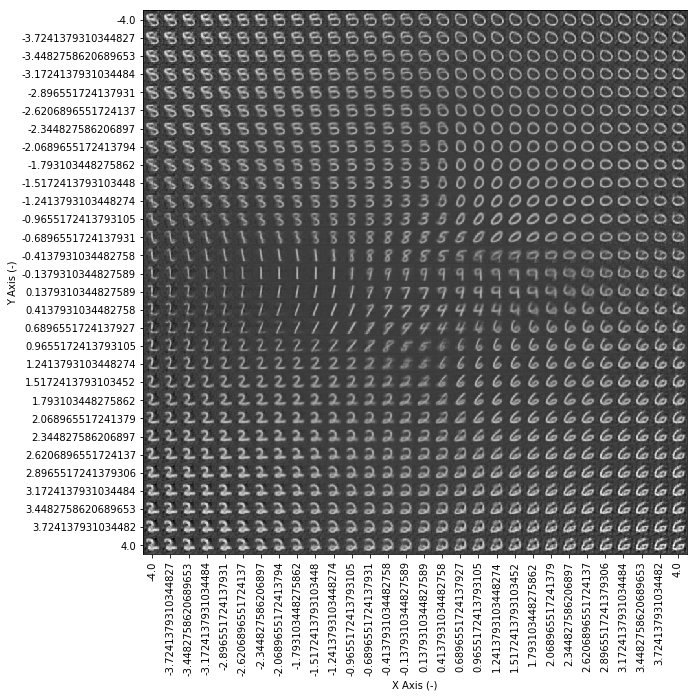

In [15]:
x_axis = np.linspace( -4.0, 4.0, 30 )

y_axis = np.linspace( -4.0, 4.0, 30 )

mat = np.zeros( shape = [ 28 * 30, 28 * 30 ] )




for i in range( 30 ):
    
    for j in range( 30 ):
        
        image = decoder.predict( np.array( [ x_axis[ i ], y_axis[ j ] ] ).reshape( [ 1, 2 ] ) )[ 0 ]
        
        up = j * 28
        
        down = up + 28
        
        left = i * 28
        
        right = left + 28
        
        mat[ up : down, left : right ] = image[ :, :, 0 ]
        
        
        
        
plt.figure( figsize = ( 10, 10 ) )

plt.imshow( mat, cmap = "Greys_r" )

ticks = [ i * 28 + 14 for i in range( 30 ) ]

plt.xticks( ticks, x_axis, rotation = 90 )

plt.yticks( ticks, y_axis )

plt.xlabel( "X Axis (-)" )

plt.ylabel( "Y Axis (-)" )